In [1]:
try: 
  %tensorflow_version 2.x
  %reload_ext tensorboard
except:
  pass

In [2]:
!git clone https://github.com/PetraVidnerova/rbf_keras.git

Cloning into 'rbf_keras'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 120 (delta 0), reused 1 (delta 0), pack-reused 116
Receiving objects: 100% (120/120), 23.88 KiB | 1.08 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import keras
from keras import layers
from rbf_keras import kmeans_initializer
from tensorflow.keras.initializers import Initializer
from rbf_keras import rbflayer
from tensorflow.keras.optimizers import RMSprop

In [4]:
def guassian(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2)

In [5]:
path='/content/drive/MyDrive/ANN_Data/HW03/auto-mpg.csv'
data = pd.read_csv(path,na_values=['NA', '?'])
print(f"horsepower has na? {pd.isnull(data['horsepower']).values.any()}")

for index, row in data.iterrows():
    for col in data.columns:
        if row[col]=='?':
          print(index,col)

med = data['horsepower'].median()
print(med)
data['horsepower'] = data['horsepower'].fillna(med)
print(f"horsepower has na? {pd.isnull(data['horsepower']).values.any()}")

horsepower has na? True
93.5
horsepower has na? False


In [7]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X = data.drop(['mpg','car name'],axis=1).values   # independant features
y = data[['mpg']].values				# dependant variable


min_max_scaler_x = preprocessing.MinMaxScaler()
normalized_x = min_max_scaler_x.fit_transform(X)
X = pd.DataFrame(normalized_x)

min_max_scaler_y = preprocessing.MinMaxScaler()
normalized_y = min_max_scaler_y.fit_transform(y)
y = pd.DataFrame(normalized_y)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [8]:
from itertools import combinations
from random import randint
import math
import numpy as np
from numpy.linalg import qr, inv, norm

In [9]:
def square_distance(x,y): return sum([(xi-yi)**2 for xi, yi in zip(x,y)])    

In [10]:
row_list=[]
for i in range(len(X_train)):
  row_list.append(list(X_train.iloc[i]))

max_square_distance = 0
for pair in combinations(row_list,2):
    if square_distance(*pair) > max_square_distance:
        max_square_distance = square_distance(*pair)
        max_pair = pair
max_distance = np.sqrt(square_distance(max_pair[0],max_pair[1]))

In [11]:
k = 100
sigma = max_distance/np.sqrt(2*k)
P = list()

for x in X_train.values:
  c  = X_train.sample(n=1).values
  g = guassian(x,c,sigma)
  P.append(g.flatten())

Q , R = qr(P)
H = np.dot(Q.T,Q)
H_inv  = inv(H)
g = np.dot(H_inv,Q.T)
g_hat = np.dot(g,y_train)
E = y_train - np.dot(Q,g_hat)

l = np.zeros(shape=(Q.shape[0],1))
for i in range(Q.shape[0]):
  l[i] = (np.dot(Q[i].T,Q[i])+ np.dot(E.T,E))
l = np.ndarray.flatten(l)
l_sorted = l.argsort()[::-1][:Q.shape[0]]

In [30]:
class InitCentersOLS(Initializer):
    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter
        super().__init__()

    def __call__(self, shape, dtype=None):
      centers = np.zeros(shape=shape)
      for i in range(shape[0]):
         np.append(centers, X.iloc[int(l_sorted[i])])
      return centers

In [31]:
def OLS(k):
  k = 100
  sigma = max_distance/np.sqrt(2*k)
  P = list()

  for x in X_train.values:
    c  = X_train.sample(n=1).values
    g = guassian(x,c,sigma)
    P.append(g.flatten())

  Q , R = qr(P)
  H = np.dot(Q.T,Q)
  H_inv  = inv(H)
  g = np.dot(H_inv,Q.T)
  g_hat = np.dot(g,y_train)
  E = y_train - np.dot(Q,g_hat)

  l = np.zeros(shape=(Q.shape[0],1))
  for i in range(Q.shape[0]):
    l[i] = (np.dot(Q[i].T,Q[i])+ np.dot(E.T,E))
  l = np.ndarray.flatten(l)
  l_sorted = l.argsort()[::-1][:Q.shape[0]]

  rbfLayer = rbflayer.RBFLayer(k,initializer=InitCentersOLS(X),
                             betas=4.0,
                             input_shape=(7,))
  model = keras.models.Sequential()
  model.add(layers.Input(shape=(7),name="Input_layer"))
  model.add(rbfLayer)
  model.add(layers.Dense(1))
  model.compile(loss='mse',optimizer=RMSprop())

  return model


In [32]:
ks = np.array([5,10,50,100,150])
models = []
for k in ks:
  model = OLS(k)  
  model.compile(loss='mse',optimizer=RMSprop())
  models.append(model)

In [ ]:
histories=[]
for model in models:
  history = model.fit(X_train,y_train,epochs=1000, validation_split=0.125)
  print("*"*100)
  histories.append(history)

Streaming output truncated to the last 5000 lines.
Epoch 980/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 981/1000
9/9 [==============================] - 0s 9ms/step - loss: 0.0040 - val_loss: 0.0049
Epoch 982/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0040 - val_loss: 0.0054
Epoch 983/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0039 - val_loss: 0.0053
Epoch 984/1000
9/9 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.0050
Epoch 985/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 986/1000
9/9 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0049
Epoch 987/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 988/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 989/1000
9/9 [============================

In [35]:
for model in models:
  model.evaluate(X_test,y_test)
  print("*"*50)

3/3 [==============================] - 0s 4ms/step - loss: 0.0034
**************************************************
3/3 [==============================] - 0s 5ms/step - loss: 0.0039
**************************************************
3/3 [==============================] - 0s 5ms/step - loss: 0.0044
**************************************************
3/3 [==============================] - 0s 5ms/step - loss: 0.0042
**************************************************
3/3 [==============================] - 0s 4ms/step - loss: 0.0059
**************************************************


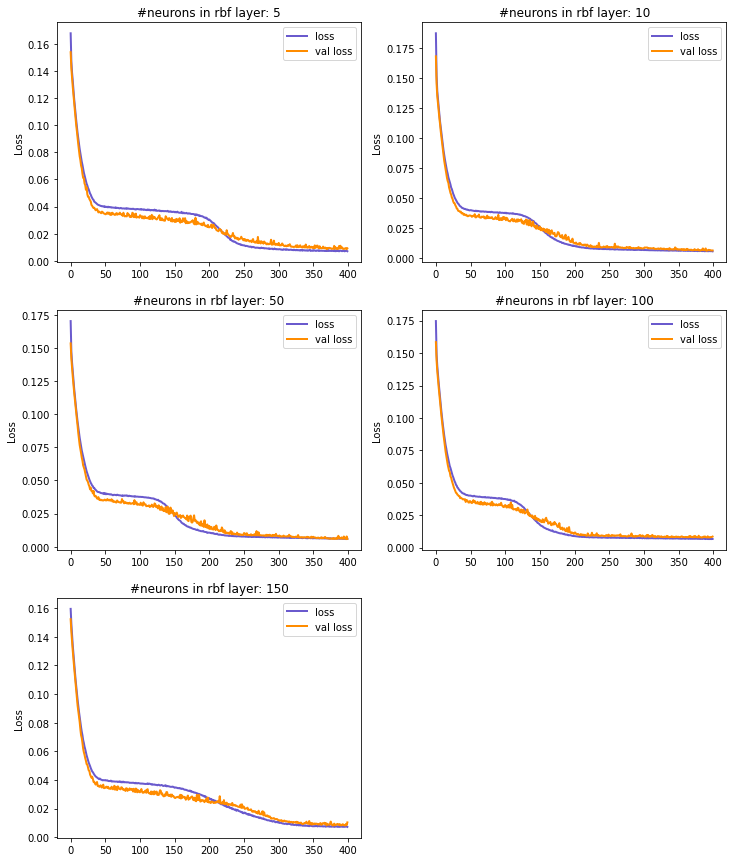

In [28]:
plt.figure(figsize=(12,15))
for i,history in enumerate(histories):
  plt.subplot(3, 2, i+1)
  plt.plot(history.history['loss'], label = 'loss',c="slateblue",linewidth=2)
  plt.plot(history.history['val_loss'], label='val loss',c="darkorange",linewidth=2)
  # plt.grid(True)
  plt.title("#neurons in rbf layer: "+str(ks[i]))
  plt.ylabel("Loss")
  plt.legend()
plt.savefig("part_3_2")

## one at a time

In [13]:
rbfLayer = rbflayer.RBFLayer(k,initializer=InitCentersOLS(X),
                             betas=4.0,
                             input_shape=(7,))
model = keras.models.Sequential()
model.add(rbfLayer)
model.add(layers.Dense(1))

In [14]:
model.compile(loss='mse',
              optimizer=RMSprop())

In [15]:
history = model.fit( X_train,y_train, epochs=1000,validation_split= 0.125)

Epoch 1/1000
9/9 [==============================] - 1s 29ms/step - loss: 0.1656 - val_loss: 0.1527
Epoch 2/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.1473 - val_loss: 0.1425
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.1400 - val_loss: 0.1356
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.1334 - val_loss: 0.1293
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.1267 - val_loss: 0.1232
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.1210 - val_loss: 0.1175
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.1150 - val_loss: 0.1117
Epoch 8/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.1094 - val_loss: 0.1065
Epoch 9/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.1049 - val_loss: 0.1015
Epoch 10/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.0996 - val_loss: 0.0963
Epoch 11/1000
9/9 

In [16]:
model.evaluate(X_test,y_test)

3/3 [==============================] - 0s 5ms/step - loss: 0.0040


0.004047446884214878

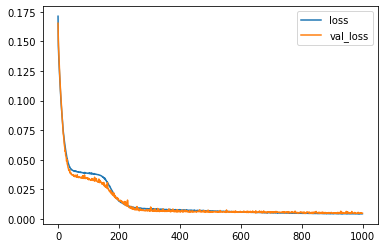

In [ ]:
pd.DataFrame(history.history).plot()